# Import the Data

In [1]:
import unicodedata
import glob
import os
import string
import torch
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import regex as re

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    # Put a space before all punctuation
    s = re.sub(r"([.!?])", r" \1", s)
    # Remove any non characters or punctuation other than ! and ?
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [2]:
# Read the file and split into lines
lines = open('../data/eng-fra.txt', encoding='utf-8').read()
lines = lines.strip().split('\n')

In [3]:
pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

In [4]:
len(pairs)

135842

# Filter to Dataset

In [5]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[0].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [6]:
pairs = filterPairs(pairs)

In [7]:
pairs = [[x[1], x[0]] for x in pairs]

# Encode data into numerical tensors

In [8]:
SOS_token = 0
EOS_token = 1

In [9]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.index2word = {0: "<SOS>", 1: "<EOS>"}
        self.word2index = {"<SOS>": 0, "<EOS>": 1}
        self.n_words = 2
        self.word2count = {}
    
    def addWord(self, word):
        if word not in self.word2index:
            ind = self.n_words
            self.index2word[ind] = word
            self.word2index[word] = ind
            self.n_words += 1
            self.word2count[word] = 1
        else:
            self.word2count[word] += 1
    
    def addSentence(self, sentence):
        for word in sentence.split(" "):
            self.addWord(word)

In [10]:
eng = Lang("English")
fra = Lang("French")

In [11]:
for (fra_sentence, eng_sentence) in pairs:
    fra.addSentence(fra_sentence)
    eng.addSentence(eng_sentence)

In [12]:
fra_sentence

'c est un representant accredite du gouvernement canadien'

In [13]:
def sentenceToIndices(sentence, lang):
    indices = [lang.word2index[word] for word in sentence.split(' ')]
    indices.append(EOS_token)
    indices.insert(SOS_token, 0)
    indices = torch.tensor(indices, dtype = torch.long)
    return indices

# Define the Neural Network

In [14]:
import torch.nn as nn

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p = 0.1):
        super(EncoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first = True)
        self.dropout = nn.Dropout(dropout_p)
    
    def forward(self, input, hidden):
        
#         print("Input Size: ", input.shape)
        embedded = self.dropout(self.embedding(input))
#         print("Embedded Size: ", embedded.shape)
        output, hidden = self.gru(embedded, hidden)
#         print("Output Size: ", output.shape)
#         print("Hidden Size: ", hidden.shape)

        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [15]:
encoder = EncoderRNN(input_size = fra.n_words, hidden_size = 128)

In [22]:
import torch.nn as nn

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p = 0.1):
        super(DecoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first = True)
        self.dropout = nn.Dropout(dropout_p)
        
        self.softmax = nn.LogSoftmax(dim = 1)
        
        self.o2o = nn.Linear(hidden_size, output_size)
        
        
    def forward_step(self, input, hidden):
        
        output, hidden = self.gru(input, hidden)
#         print("Output size: ", output.shape)
        
        return output, hidden
    
    def forward(self, input, encoder_hidden):
        
        padded_input = torch.empty(MAX_LENGTH + 1, dtype = torch.long).fill_(SOS_token)
        
        seq_len = input.size()[0]
        hidden = encoder_hidden
        
        for i in range(seq_len):
            padded_input[i] = input[i]
        
#         print("Input Size: ", input.shape)
        
        embedded = self.dropout(self.embedding(padded_input))
#         print("Embedded Size: ", embedded.shape)
        
        outputs = torch.zeros((MAX_LENGTH + 1, self.hidden_size))
#         print()
        
        for i in range(MAX_LENGTH + 1):
#             print(i)
            output, hidden = self.forward_step(embedded[i:i+1], hidden)
            outputs[i, :] = output
#         print()
            
#         print("Outputs Size: ", outputs.shape)
#         print("Hidden Size: ", hidden.shape)

        outputs = self.o2o(outputs)
        outputs = self.softmax(outputs)

        return outputs, hidden

In [23]:
decoder = DecoderRNN(hidden_size = 128, output_size = eng.n_words)

# Pass an example through our Neural Network

In [24]:
# Encoder

fra_sentence, eng_sentence = pairs[-1]
fra_tensor = sentenceToIndices(fra_sentence, fra)
hidden = encoder.initHidden()
outputs, encoder_hidden = encoder(fra_tensor, hidden)

In [25]:
# Decoder 
eng_tensor = sentenceToIndices(eng_sentence, eng)

outputs, hidden = decoder(eng_tensor, encoder_hidden)

In [28]:
criterion = nn.NLLLoss()

In [29]:
seq_len = eng_tensor.size()[0]

targets = eng_tensor[1:]

total_loss = torch.Tensor([0])
for i in range(seq_len - 1):
    loss = criterion(outputs[i], targets[i])
    total_loss += loss
total_loss /= (seq_len - 1)

# Train our NN

In [30]:
n_iters = 100000
learning_rate = 0.005

all_losses = []

avg_loss = 0
n_checkpoint = 1000

for i in range(1, n_iters + 1):
    
    fra_sentence, eng_sentence = random.sample(pairs, 1)[0]
    
    encoder.zero_grad()
    decoder.zero_grad()
    
    # Encoder
    hidden = encoder.initHidden()
    fra_tensor = sentenceToIndices(fra_sentence, fra)
    
    outputs, encoder_hidden = encoder(fra_tensor, hidden)
    
    # Decoder 
    eng_tensor = sentenceToIndices(eng_sentence, eng)

    outputs, hidden = decoder(eng_tensor, encoder_hidden)

    seq_len = eng_tensor.size()[0]

    targets = eng_tensor[1:]

    loss = torch.Tensor([0])
    for j in range(seq_len - 1):
        l = criterion(outputs[j], targets[j])
        loss += l
    loss /= (seq_len - 1)
    
    loss.backward()
    
    avg_loss += loss
        
    if i % n_checkpoint == 0:
        avg_loss /= n_checkpoint
        print("Iterations: ", i)
        print("Average loss: ", round(avg_loss.item(), 4))
        
        all_losses.append((i, round(avg_loss.item(), 4)))
        
        avg_loss = 0
    
    for p in encoder.parameters():
        p.data.add_(p.grad.data, alpha = -learning_rate)
    for p in decoder.parameters():
        p.data.add_(p.grad.data, alpha = -learning_rate)

Iterations:  1000
Average loss:  6.6896
Iterations:  2000
Average loss:  4.6935
Iterations:  3000
Average loss:  4.185
Iterations:  4000
Average loss:  3.9988
Iterations:  5000
Average loss:  3.8478
Iterations:  6000
Average loss:  3.7593
Iterations:  7000
Average loss:  3.7218
Iterations:  8000
Average loss:  3.6419
Iterations:  9000
Average loss:  3.6402
Iterations:  10000
Average loss:  3.5908
Iterations:  11000
Average loss:  3.5874
Iterations:  12000
Average loss:  3.5732
Iterations:  13000
Average loss:  3.531
Iterations:  14000
Average loss:  3.4717
Iterations:  15000
Average loss:  3.4656
Iterations:  16000
Average loss:  3.4017
Iterations:  17000
Average loss:  3.377
Iterations:  18000
Average loss:  3.3696
Iterations:  19000
Average loss:  3.3187
Iterations:  20000
Average loss:  3.3054
Iterations:  21000
Average loss:  3.3302
Iterations:  22000
Average loss:  3.2737
Iterations:  23000
Average loss:  3.2915
Iterations:  24000
Average loss:  3.2043
Iterations:  25000
Average l

# Plot the learning curve

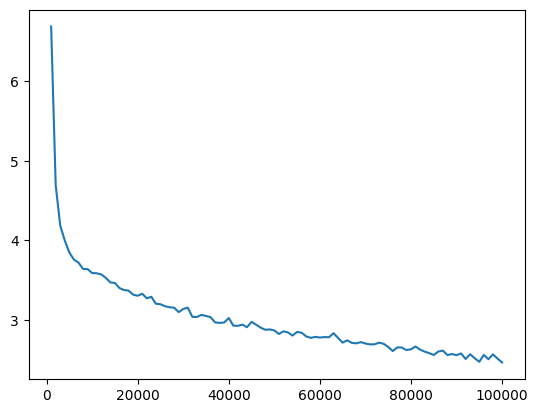

In [31]:
plt.figure()
plt.plot([x[0] for x in all_losses], [x[1] for x in all_losses])

# Evaluating on some inputs

In [89]:
eng_sentence = "I am scared of big dogs."

In [90]:
fra_sentence = "J'ai peur des gros chiens."

In [91]:
fra_sentence = normalizeString(fra_sentence)

In [96]:
def predict(fra_sentence):
    
    # Encoder
    hidden = encoder.initHidden()
    fra_tensor = sentenceToIndices(fra_sentence, fra)
    outputs, encoder_hidden = encoder(fra_tensor, hidden)
    
    # Decoder
    input = torch.tensor([SOS_token], dtype = torch.long)
    eng_sentence = []
    hidden = encoder_hidden

    for i in range(MAX_LENGTH + 1):
        outputs, hidden = decoder(input, hidden)
        output = outputs[0]
        val, pred_ind = output.topk(1, 0, True)
        next_word = eng.index2word[pred_ind.item()]
        input = pred_ind

        if pred_ind == EOS_token:
            break;
            
        eng_sentence.append(next_word)
    
    return " ".join(eng_sentence)

In [97]:
predict(fra_sentence)

'i m a good at all happy'

In [98]:
for i in range(10):
    fra_sentence, eng_sentence = random.sample(pairs, 1)[0]
    translation = predict(fra_sentence)
    
    print("French Sentence: ", fra_sentence)
    print("English Sentence: ", eng_sentence)
    print("Predicted English Sentence Translation: ", translation)
    print()

French Sentence:  je ne suis pas alcoolique
English Sentence:  i m not an alcoholic
Predicted English Sentence Translation:  i m not a good not are as s a good

French Sentence:  nous sommes prudents
English Sentence:  we re careful
Predicted English Sentence Translation:  we re all happy

French Sentence:  tu es fiable
English Sentence:  you re trustworthy
Predicted English Sentence Translation:  you re all happy

French Sentence:  je ne suis pas un bon pecheur
English Sentence:  i m not good at fishing
Predicted English Sentence Translation:  i m not a very good not a very good at

French Sentence:  tu es un traitre
English Sentence:  you re a traitor
Predicted English Sentence Translation:  you re all a good at all a good at all

French Sentence:  je n irai pas au cinema demain
English Sentence:  i m not going to the movies tomorrow
Predicted English Sentence Translation:  i m not are not are not are not going t

French Sentence:  je suis un peu en retard sur mon planning
English Se